<a href="https://colab.research.google.com/github/Batman511/AI-Samsung-Neural-Networks/blob/main/%D0%9A%D1%83%D1%80%D1%81_AI_Samsung_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Восстановление функции с помощью нейросети

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

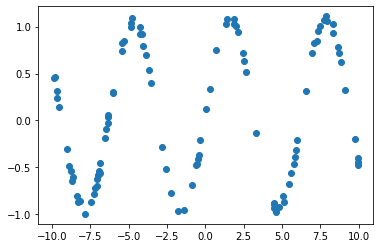

In [21]:
x_train = torch.rand(100)
x_train *=20
x_train -=10

y_train = torch.sin(x_train)
# plt.plot(x_train.numpy(), y_train.numpy(),'o')

noise = torch.rand(y_train.shape)/8.
y_train += noise

plt.plot(x_train.numpy(), y_train.numpy(),'o')

Превращаем вектор признаков в столбец

In [16]:
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)

# Сделаем валидационные данные,   СЛЕДИТЬ ЧТОБЫ БЫЛ ТОТ ЖЕ ДИАПАЗОН, ЧТО В ТРЕНИРОВОЧНЫЕ ДАННЫЕ
x_valid = torch.linspace(-10, 10, 100)
y_valid = torch.sin(x_valid.data)

x_valid.unsqueeze_(1)
y_valid.unsqueeze_(1);

Создаем Класс нейросети

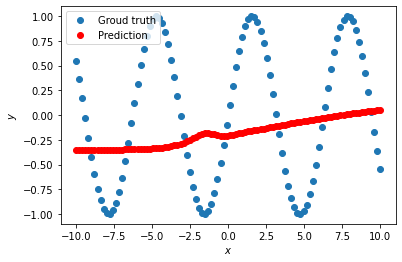

In [18]:
class SinNet(torch.nn.Module):  # наследуем от класса nn.Module
    def __init__(self, n_hidden_neurons):   # число скрытых нейронов в каждом слое
        super(SinNet, self).__init__()  # инициализируем родительский объект
        self.fc1 = torch.nn.Linear(1,n_hidden_neurons)  # первый слой с числом входных и выходных нейронов
        self.act1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1) # выходной слой с одним выходом тк задача регрессии

    # последовательное применение слоев, т.е. ИНИЦИАЛИЗАЦИЯ
    def forward(self,x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

sin_net = SinNet(12)

def predict(net,x,y):
    y_pred = net.forward(x)  # предсказываем
    # рисуем
    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

predict(sin_net,x_valid,y_valid)

Обучаем нейросеть

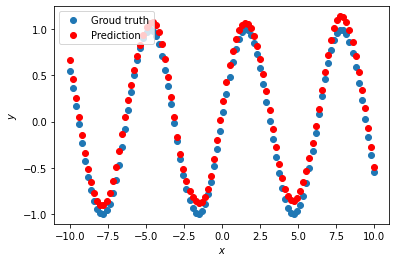

In [19]:
optimazer = torch.optim.Adam(sin_net.parameters(), lr=0.01)  # в parameters() лежат веса нейронов (настроиваемые) поэтому и наследовали
# оптимайзер оборачивает все параметры нейросети

def loss(pred,target):
    sq = (pred-target)**2
    return sq.mean()

for epoch_index in range(2000):
    optimazer.zero_grad()  # зануляем градиенты
    y_pred = sin_net.forward(x_train)
    loss_val = loss(y_pred,y_train)
    loss_val.backward()  # для оптимайзера
    optimazer.step()

predict(sin_net, x_valid, y_valid)

## Вторая функция

In [3]:
import torch

def target_function(x):
    return 2**x * torch.sin(2**-x)

class RegressionNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):   # число скрытых нейронов в каждом слое
        super(RegressionNet, self).__init__()  # инициализируем родительский объект
        self.fc1 = torch.nn.Linear(1,n_hidden_neurons)  # первый слой с числом входных и выходных нейронов
        self.fc2 = torch.nn.Linear(n_hidden_neurons,n_hidden_neurons)
        self.act1 = torch.nn.Tanh()
        self.act2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1) # выходной слой с одним выходом тк задача регрессии

    def forward(self,x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

net = RegressionNet(30)

# ------Dataset preparation start--------:
x_train =  torch.linspace(-10, 5, 100)
y_train = target_function(x_train)
noise = torch.randn(y_train.shape) / 20.
y_train = y_train + noise
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)

x_validation = torch.linspace(-10, 5, 100)
y_validation = target_function(x_validation)
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1)
# ------Dataset preparation end--------:


optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)

def loss(pred, target):
    sq = abs(pred-target)
    return sq.mean()

for epoch_index in range(2000):
    optimizer.zero_grad()

    y_pred = net.forward(x_train)
    loss_value = loss(y_pred, y_train)
    loss_value.backward()
    optimizer.step()

# Проверка:
def metric(pred, target):
   return (pred - target).abs().mean()

print(metric(net.forward(x_validation), y_validation).item())

0.02594063989818096
